# Unlearning with Neggrad

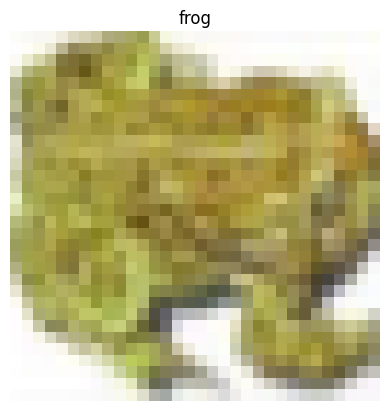

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.nn.functional import relu, avg_pool2d
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from itertools import cycle

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import time
import random

from cifar import load_cifar10_data, split_into_classes, get_class_indexes 

# import quadprog

import os
import sys
sys.path.append(os.path.abspath("."))  # Adds the current directory

In [2]:
# Path to the dataset
DATASET_PATH = 'cifar-10-batches-py' 
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_data, train_labels, test_data, test_labels = load_cifar10_data(DATASET_PATH)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# split the data into 10 classes by doing sort by key where in the keys are the labels and the values are the data
train_split = {cls: [] for cls in CLASSES}
for img, label in zip(train_data, train_labels):
    train_split[CLASSES[label]].append(img)
    
# this makes more sense to me, effectively indexes 0-5000 are all airplanes, 5000-10000 are all automobiles etc
test_split = {cls: [] for cls in CLASSES}
for img, label in zip(test_data, test_labels):
    test_split[CLASSES[label]].append(img)

In [3]:
initialisation = time.time()

class ResNet18CIFAR(torch.nn.Module):
    def __init__(self):
        super(ResNet18CIFAR, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        # change the first layer to accept 32x32 images with 3 channels rather than 224x224 images
        # check the size of the input layer
        self.resnet.conv1 = torch.nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.resnet.bn1 = torch.nn.BatchNorm2d(128)
        # change number of blocks per layer
        self.resnet.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(128)
        )
        self.resnet.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(256)
        )
        self.resnet.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(512)
        )
        self.resnet.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(1024)
        )
        # change input layer to accept 32x32 images by utilising smaller convolutional kernel
        self.resnet.fc = torch.nn.Linear(1024, 10)
        # start with 5 classes and add more as needed
        self.resnet.maxpool = torch.nn.Identity()
        # maxpool worsens performance and is unnecessary for small image sizes
        

    def forward(self, x):
        return self.resnet(x)
    
model = ResNet18CIFAR()
model = torch.load("""models\\resnet18_cifar77ACC.pth""")


Using cache found in C:\Users\Tom/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\Tom\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Tom\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Tom\AppData\Local\Temp\ipykernel_9444\904961702.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blo

In [ ]:
# turn the data into a tensor
test_data_tensor = torch.tensor(test_data).float()
test_labels_tensor = torch.tensor(test_labels)

train_data_tensor = torch.tensor(train_data, dtype=torch.float32).cuda()
train_labels_tensor = torch.tensor(train_labels).cuda()

# Define the number of classes in your dataset
num_classes = 10

# Move tensors to GPU if available
if torch.cuda.is_available():
    test_data_tensor = test_data_tensor.cuda()
    test_labels_tensor = test_labels_tensor.cuda()

In [ ]:
def evaluate_model(model):
    print("||===================START CLASS-BY-CLASS ACCURACY=================||")
    # Initialize counters for each class
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    # Test the model
    with torch.no_grad():
        for i in range(0, len(test_data), 1000):
            # Get the input and output
            img = test_data_tensor[i:i + 1000]
            label = test_labels_tensor[i:i + 1000]
            
            model = model.cuda()

            # Get the prediction
            outputs = model(img)
            _, predicted = torch.max(outputs, 1)

            # Update per-class counters
            for lbl, pred in zip(label, predicted):
                class_total[lbl.item()] += 1
                if lbl.item() == pred.item():
                    class_correct[lbl.item()] += 1

            del img

    # Print overall accuracy
    overall_accuracy = sum(class_correct) / sum(class_total) * 100
    print(f"|| Overall Test Accuracy: {overall_accuracy:.2f}% ||")

    # Print accuracy for each class
    for cls in range(num_classes):
        if class_total[cls] > 0:
            class_accuracy = class_correct[cls] / class_total[cls] * 100
            print(f"|| Accuracy for Class {cls}: {class_accuracy:.2f}% ||")
        else:
            print(f"|| No samples for Class {cls} ||")

In [6]:
classes_to_unlearn = [0,1,2,3,4]
forget_mask = torch.isin(train_labels_tensor, torch.tensor(classes_to_unlearn).cuda())
retain_mask = ~forget_mask

test_forget_mask = torch.isin(test_labels_tensor, torch.tensor(classes_to_unlearn).cuda())
test_retain_mask = ~test_forget_mask

# Get the indices of the forget and retain subsets
forget_indices = forget_mask.nonzero(as_tuple=True)[0]
retain_indices = retain_mask.nonzero(as_tuple=True)[0]
test_forget_indices = test_forget_mask.nonzero(as_tuple=True)[0]
test_retain_indices = test_retain_mask.nonzero(as_tuple=True)[0]

forget_dataset = TensorDataset(train_data_tensor[forget_indices], train_labels_tensor[forget_indices])
retain_dataset = TensorDataset(train_data_tensor[retain_indices], train_labels_tensor[retain_indices])
test_forget_dataset = TensorDataset(test_data_tensor[test_forget_indices], test_labels_tensor[test_forget_indices])
test_retain_dataset = TensorDataset(test_data_tensor[test_retain_indices], test_labels_tensor[test_retain_indices])

forget = DataLoader(forget_dataset, batch_size=64, shuffle=True)
retain = DataLoader(retain_dataset, batch_size=64, shuffle=True)
test_forget = DataLoader(test_forget_dataset, batch_size=64, shuffle=False)
test_retain = DataLoader(test_retain_dataset, batch_size=64, shuffle=False)

In [7]:
def Neggrad_one_epoch(model, criterion, optimiser, retain_loader : DataLoader, forget_loader : DataLoader, alpha):
    model.train()

    for idx, ((input, target), (del_input, del_target)) in enumerate(zip(retain_loader, cycle(forget_loader))):
        # if(idx % 1 == 0): print(idx)
        input = input.cuda()
        target = target.cuda()
        del_input = del_input.cuda()
        del_target = del_target.cuda()

        # Forward
        output_clean = model(input)
        del_output_clean = model(del_input)
        r_loss = criterion(output_clean, target)
        del_loss = criterion(del_output_clean, del_target)

        loss = alpha*r_loss - (1-alpha)*del_loss

        # Backward
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        loss = loss.float()

In [8]:
# def evaluate_model(model, criterion, test_retain_loader : DataLoader, test_forget_loader : DataLoader):
#     model.eval()
#     sum_loss = 0
#     total = 0
#     with torch.no_grad():
#         for test_input, test_target in test_retain_loader:
#             test_input = test_input.cuda()
#             test_target = test_target.cuda()

#             outputs = model(test_input)
#             loss = criterion(outputs, test_target)
#             sum_loss += loss.item() * test_input.size(0)
#             total += test_input.size(0)
#         retain_accuracy = sum_loss / total
#         sum_loss = 0
#         total = 0
#         for test_input, test_target in test_forget_loader:
#             test_input = test_input.cuda()
#             test_target = test_target.cuda()

#             outputs = model(test_input)
#             loss = criterion(outputs, test_target)
#             sum_loss += loss.item() * test_input.size(0)
#             total += test_input.size(0)
#         forget_accuracy = sum_loss / total

#     return retain_accuracy, forget_accuracy




In [9]:
EPOCHS = 3
ALPHA = 0.999

In [ ]:
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
model = model.cuda()

evaluate_model(model)

for i in range(EPOCHS):
    print(f"Epoch {i + 1}/{EPOCHS}:",end=None)
    start = time.time()
    Neggrad_one_epoch(model,criterion,optimiser, retain, forget, ALPHA)
    print(f"({time.time() - start})")
    evaluate_model(model)
    
    
    

||===================START CLASS-BY-CLASS ACCURACY=================||
|| Overall Test Accuracy: 77.33% ||
|| Accuracy for Class 0: 83.00% ||
|| Accuracy for Class 1: 88.00% ||
|| Accuracy for Class 2: 63.10% ||
|| Accuracy for Class 3: 58.30% ||
|| Accuracy for Class 4: 72.60% ||
|| Accuracy for Class 5: 66.00% ||
|| Accuracy for Class 6: 84.10% ||
|| Accuracy for Class 7: 82.50% ||
|| Accuracy for Class 8: 87.20% ||
|| Accuracy for Class 9: 88.50% ||
Epoch 1/3:
